# Import Library

In [140]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from omegaconf import OmegaConf


In [141]:
parent_dir = Path().resolve().parent
print(f"current dir: {parent_dir}")

current dir: /home/kazuki/data/analysis_brain_data


# Read Config

In [142]:
config = OmegaConf.load("config//analysis.yaml")

brain_data_path = parent_dir / Path(config.paths.brain_data_path)
print(brain_data_path)

name_list = ["time", "left cerebral blood", "right cerebral blood", "left pulse", "right pulse"]

/home/kazuki/data/analysis_brain_data/data/brain_data


main関数を利用することで、脳波データが含まれるディレクトリパス、カラム名のリストを引数に入れればデータ・線形回帰の結果をプロットできます

# Function

In [143]:
def load_data(data_dir_path: Path) -> list[pd.DataFrame]:
    """
    Load data from csv files in the specified directory.
    Parameters
        data_dir_path: Directory path containing csv files.
    Returns
        data_list: List of dataframes read from csv files.
    """
    data_path_list = list(Path(data_dir_path).rglob("*.csv"))

    # ディレクトリ内にcsvファイルが存在しない場合はエラーを出力
    assert len(data_path_list) > 0, f"No csv files found in {data_dir_path}"
    
    # データを読み込み、列名を変更し、リストに格納
    data_list = []
    for data_path in data_path_list:
        data = pd.read_csv(data_path)
        data_renamed = rename_columns(data, name_list)
        data_list.append(data_renamed)
    return data_list

def rename_columns(data: pd.DataFrame, name_list: list[str]) -> pd.DataFrame:
    """
    Rename columns in the dataframe.
    Parameters
        data: Dataframe to rename columns.
    Returns
        data: Dataframe with renamed columns.
    """
    # シフト処理を行っていない脳血流データの列を削除
    data_removed = data.drop(columns=[data.columns[1], data.columns[3]])
    # 列名を変更
    for i, name in enumerate(name_list):
        data_removed = data_removed.rename(columns={data_removed.columns[i]: name})

    return data_removed

def delete_rows():
    pass

def split_data_list(data_list: list[pd.DataFrame]) -> dict[list[pd.DataFrame]]:
    """
    Split the data list into 3 parts: 0-back_1, 0-back_2, 2-back_1.
    Parameters
        data_list: List of dataframes to split.
    Returns
        split_data_list: List of dictionaries containing split dataframes.
    """
    split_data_list = []

    for data in data_list:

        data_dict = {"0-back_1": [], 
                    "0-back_2": [], 
                    "2-back_1": []}
        
        split_index = []
        for i, (idx, row) in enumerate(data.iterrows()):
            for m in ["M1", "M2", "M3", "M4", "M5", "M6"]:
                if row[m] == 1:
                    split_index.append(i)

        data_dict["0-back_1"] = data.iloc[split_index[0]:split_index[1]]
        data_dict["0-back_2"] = data.iloc[split_index[1]:split_index[2]]
        data_dict["2-back_1"] = data.iloc[split_index[2]:split_index[3]]

        split_data_list.append(data_dict)

    return split_data_list

def linear_regression(data: pd.DataFrame) -> dict[np.ndarray|float]:
    """
    Perform linear regression on the data.
    Parameters
        data: Dataframe to perform linear regression.
    Returns
        regression_result_dict: Dictionary containing the results of linear regression.
    """
    regression_result_dict = {"0-back_1": [],
                              "0-back_2": [],
                              "2-back_1": []}

    for i, (name, data) in enumerate(data.items(), 1):
        x = data[name_list[0]].values.reshape(-1, 1)
        y_left = data[name_list[1]].values.reshape(-1, 1)
        y_right = data[name_list[2]].values.reshape(-1, 1)

        # 脳血流左右の線形回帰
        model_left = LinearRegression()
        model_left.fit(x, y_left)
        y_left_pred = model_left.predict(x)
        slope_left = model_left.coef_[0][0]

        model_right = LinearRegression()
        model_right.fit(x, y_right)
        y_right_pred = model_right.predict(x)
        slope_right = model_right.coef_[0][0]

        # 結果を辞書にlistで格納
        regression_result_dict[name].append(x)
        regression_result_dict[name].append(y_left)
        regression_result_dict[name].append(y_right)
        regression_result_dict[name].append(y_left_pred)
        regression_result_dict[name].append(y_right_pred)
        regression_result_dict[name].append(slope_left)
        regression_result_dict[name].append(slope_right)

    return regression_result_dict

def linear_regression_list(data_list: list[pd.DataFrame]) -> dict[np.ndarray|float]:
    """
    Linear regression for the list of dataframes.
    Parameters
        data_list: List of dataframes to perform linear regression.
    Returns
        regression_result_list: List of dictionaries containing the results of linear regression.
    """
    regression_result_list = []

    # データリストの各データに対して線形回帰を行い、結果をリストに格納
    for data in data_list:
        regression_result_list.append(linear_regression(data))

    return regression_result_list
        

def plot_data(name_list: list[str], data: pd.DataFrame = None, regression_result_dict: dict[np.ndarray|float] = None, regression: bool = False):
    """
    Plot the data.
    Parameters
        data: Dataframe to plot.
    """
    

    if regression:
        # 線形回帰結果をプロット
        for i, (name, data) in enumerate(regression_result_dict.items(), 1):
            plt.figure(figsize=(8, 12))
            plt.subplot(3, 1, i)
            plt.plot(data[0], data[1], label="left cerebral blood", color='blue', marker='o')
            plt.plot(data[0], data[2], label="right cerebral blood", color='red', marker='o')

            plt.plot(data[0], data[3], label=f"slope: {data[5]:.3f}", color='blue', linestyle='--')
            plt.plot(data[0], data[4], label=f"slope: {data[6]:.3f}", color='red', linestyle='--')

            plt.xlabel('time [s]')
            plt.ylabel('cerebral blood change [mM mm]')
            plt.ylim(-0.5, 1.0)
            plt.title(f'{name} cerebral blood change')

            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    else:
        # データをプロット
        for i, (name, data) in enumerate(data.items(), 1):
            plt.figure(figsize=(8, 12))
            plt.subplot(3, 1, i)
            plt.plot(data[name_list[0]], data[name_list[1]], label=name_list[1], color='blue', marker='o')
            plt.plot(data[name_list[0]], data[name_list[2]], label=name_list[2], color='red', marker='o')

            plt.xlabel('time [s]')
            plt.ylabel('cerebral blood change [mM mm]')
            plt.ylim(-0.5, 1.0)
            plt.title(f'{name} cerebral blood change')

            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

def plot_data_list(name_list: list[str], data_list: list[pd.DataFrame|dict[np.ndarray|float]] = None, regression: bool = False):
    """
    Plot the data list.
    Parameters
        data_list: List of dataframes to plot.
    """
    
    if regression:
        for data in data_list:
            plot_data(name_list, regression_result_dict=data, regression=True)
    else:
        for data in data_list:
            plot_data(name_list, data)

def main(brain_data_path: Path, name_list: list[str]):
    data_list = load_data(brain_data_path)
    splited_data_list = split_data_list(data_list)
    regression_result_list = linear_regression_list(splited_data_list)
    plot_data_list(name_list, splited_data_list)
    plot_data_list(name_list, regression_result_list, regression=True)

# Load Data And Processing

In [144]:
data_list = load_data(brain_data_path)
splited_data_list = split_data_list(data_list)
print(f"split data list length: {len(splited_data_list)}")
print(splited_data_list[0]["0-back_1"].info())
splited_data_list[0]["0-back_1"]


split data list length: 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  409 non-null    float64
 1   left cerebral blood   409 non-null    float64
 2   right cerebral blood  409 non-null    float64
 3   left pulse            409 non-null    float64
 4   right pulse           409 non-null    float64
 5   M1                    409 non-null    int64  
 6   M2                    409 non-null    int64  
 7   M3                    409 non-null    int64  
 8   M4                    409 non-null    int64  
 9   M5                    409 non-null    int64  
 10  M6                    409 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 35.3 KB
None


,time,left cerebral blood,right cerebral blood,left pulse,right pulse,M1,M2,M3,M4,M5,M6
0,6.7,-0.085795,-0.212056,78.639080,68.870546,1,0,0,0,0,0
1,6.8,-0.087364,-0.211672,78.065310,69.031466,0,0,0,0,0,0
2,6.9,-0.087324,-0.210818,77.654451,69.113290,0,0,0,0,0,0
3,7.0,-0.087451,-0.209845,77.699429,69.525719,0,0,0,0,0,0
4,7.1,-0.088248,-0.209355,77.412203,70.080115,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
404,47.1,-0.012425,-0.025322,73.827675,72.998689,0,0,0,0,0,0
405,47.2,-0.010232,-0.020125,73.742980,72.913994,0,0,0,0,0,0
406,47.3,-0.007605,-0.014850,73.570567,72.829300,0,0,0,0,0,0
407,47.4,-0.005218,-0.009748,73.219690,72.656886,0,0,0,0,0,0


# Plot Data

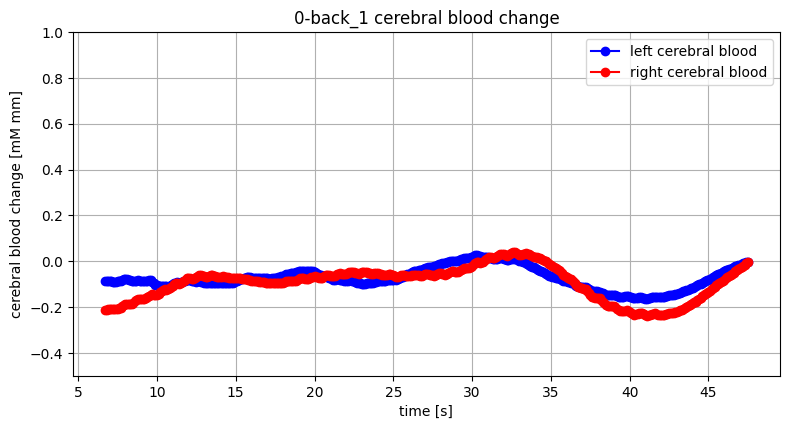

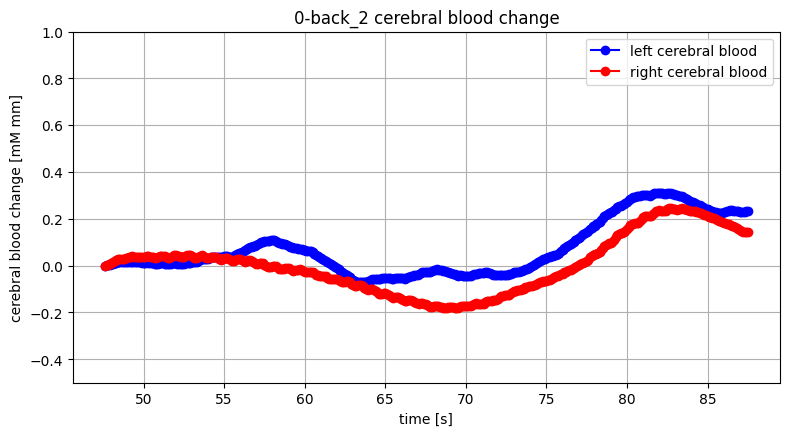

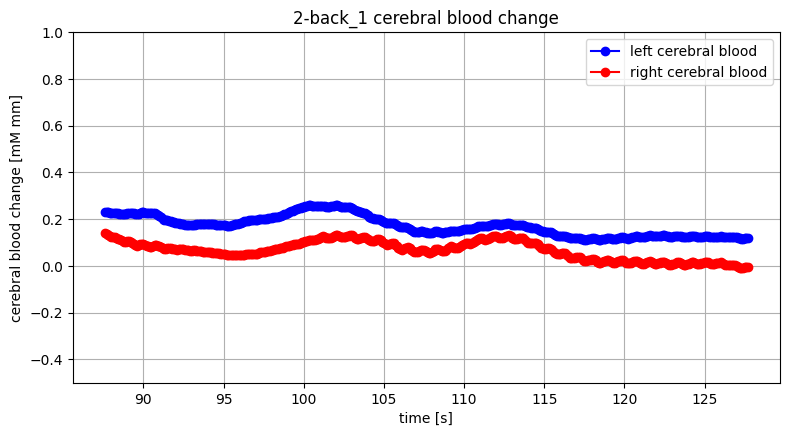

In [145]:
plot_data_list(name_list, splited_data_list)

# LinearRegression And Plot Data

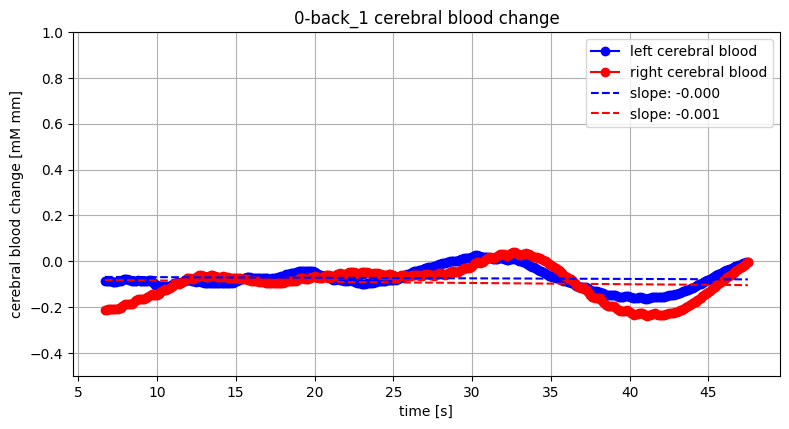

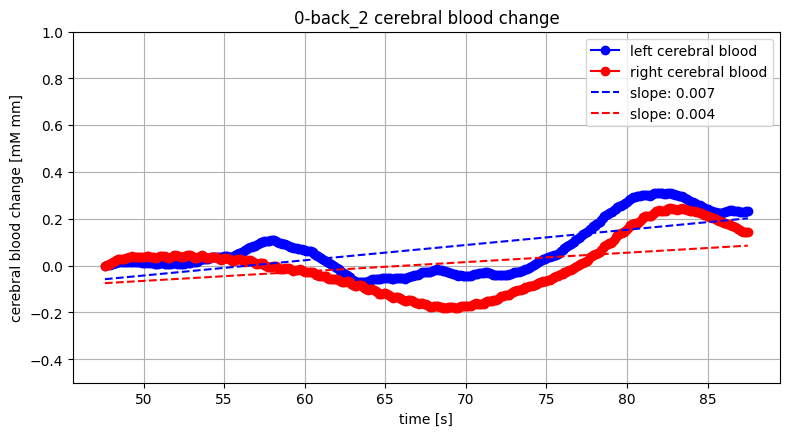

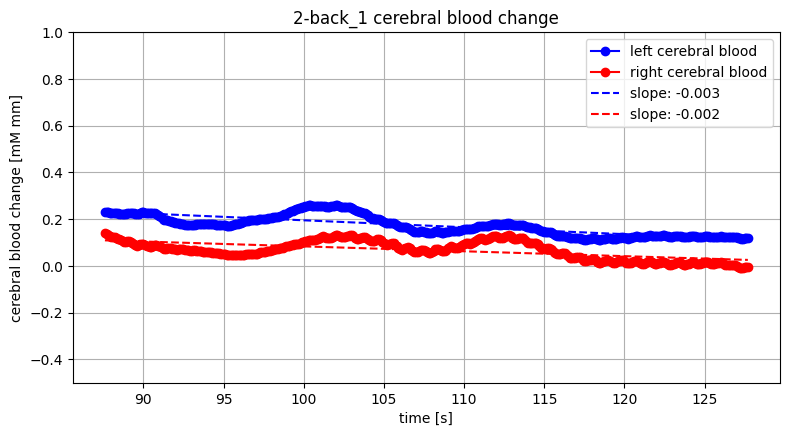

In [146]:
regression_result_list = linear_regression_list(splited_data_list)
plot_data_list(name_list, regression_result_list, regression=True)

# Exe main func

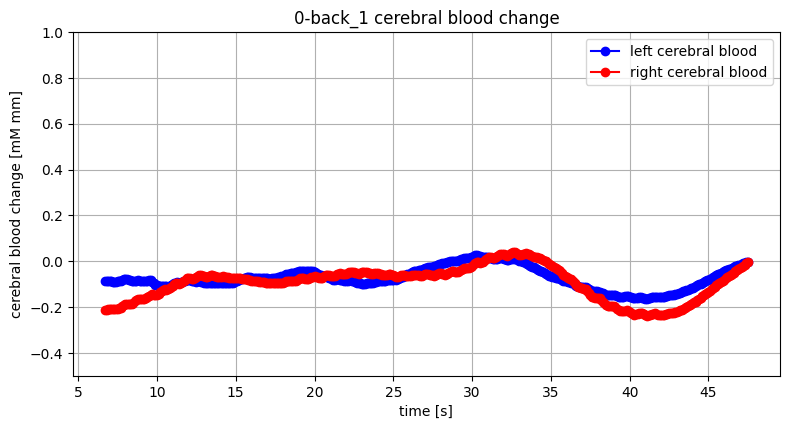

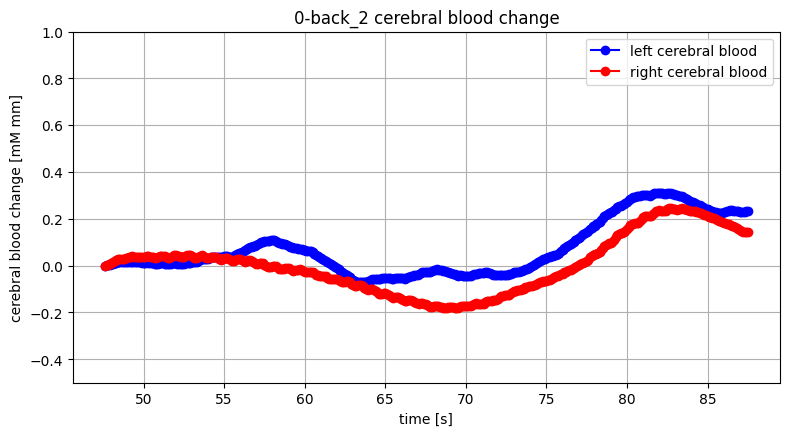

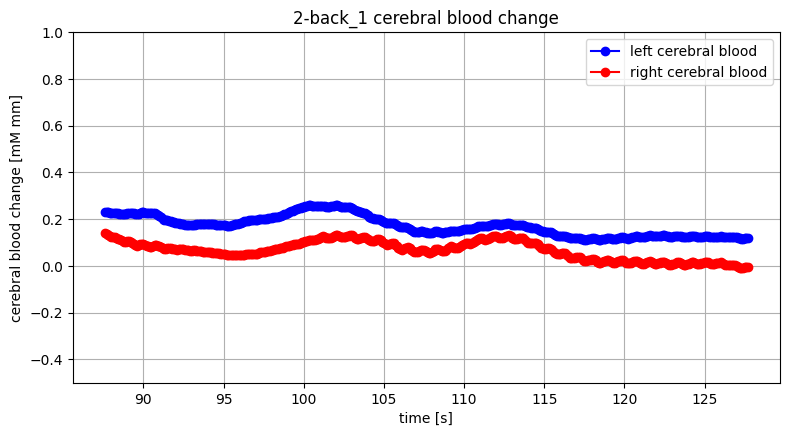

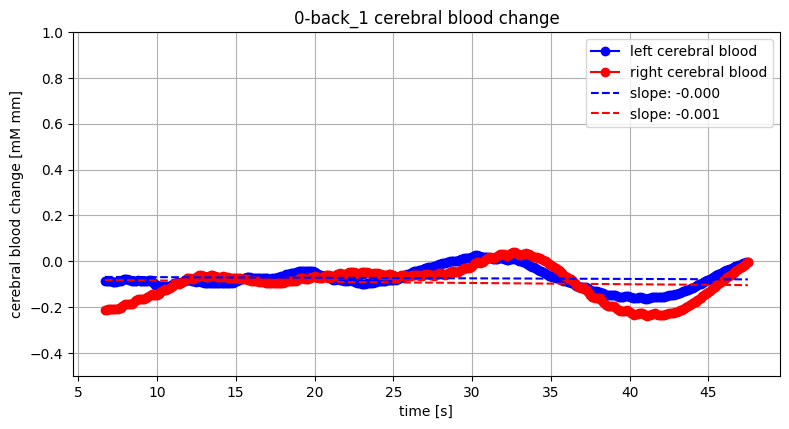

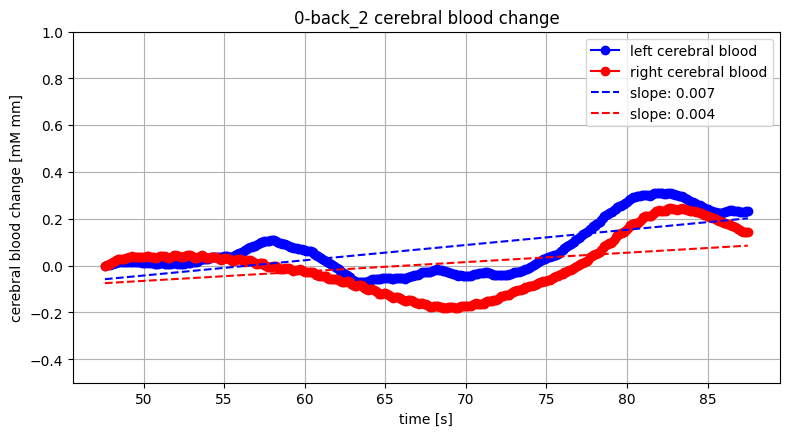

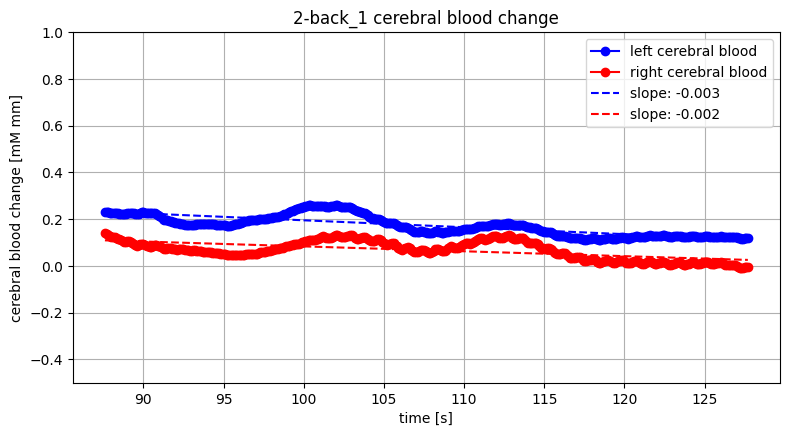

In [147]:
main(brain_data_path, name_list)